## Import Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
#Putting near the top because they're just function definitions and get in the way below.
#Found them in a kernel (https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough) and they're incredibly
#useful. Thanks, Will Koehrsen!
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    plt.style.use('fivethirtyeight')
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (12, 8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));
    
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 10.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

## Cleaning Data

In [3]:
# Replace strings with mapping from data given on Kaggle website
mapping = {'yes': 1, 'no': 0}

for df in [train, test]:
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

In [4]:
# Find households where not all members of the household have the same poverty level
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
not_equal = all_equal[all_equal != True]
# Replace them so they all have the same poverty level
for household in not_equal.index:
    correct_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    train.loc[train['idhogar'] == household, 'Target'] = correct_target

In [5]:
#Now let's look at variables missing data

# Number of missing in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train)

missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc,7928,0.829549
v18q1,7342,0.768233
v2a1,6860,0.717798
SQBmeaned,5,0.000523
meaneduc,5,0.000523
Id,0,0.000000
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


The kernel from Will Koehrsen that I referred to above has a really great treatment of the top three variables. V18q1 is missing for the families that do not own a tablet, so we set it equal to zero. V2a1 is missing for those that own their own home, and in a few other cases. For those that own their own home, we'll set it equal to zero. For the others, we'll set it equal to the median. Rez_esc is undefined for those outside the age range 7-19, so we'll set it to zero. Otherwise, we'll set it equal to the median. For meaneduc, we'll also set those missing values equal to the median. 

In [6]:
# Don't own a tablet = own 0 tablets.
train.v18q1.fillna(0, inplace=True)

# Fill in households that own the house with 0 rent payment. Otherwise, use the median.
train.loc[(train['tipovivi1'] == 1), 'v2a1'] = 0
train.v2a1.fillna(train.v2a1.median(), inplace=True)

# If individual is over 19 or younger than 7 and missing years behind, set rez_esc to 0. Otherwise, median.
train.loc[((train['age'] > 19) | (train['age'] < 7)) & (train['rez_esc'].isnull()), 'rez_esc'] = 0
train.rez_esc.fillna(train.rez_esc.median(), inplace=True)
#There's also apparently an outlier in rez_esc. This fixes it.
train.loc[train['rez_esc'] > 5, 'rez_esc'] = 5

# Meaneduc filled with median.
train.meaneduc.fillna(train.meaneduc.median(), inplace=True)
train.SQBmeaned.fillna(train.SQBmeaned.median(), inplace=True)

## Visualizing Data
The most useful information will be understanding distributions of variables by their level of poverty. From my initial checks with the Random Forest below, I have some understanding of the most important variables, so I'll look at them here. 

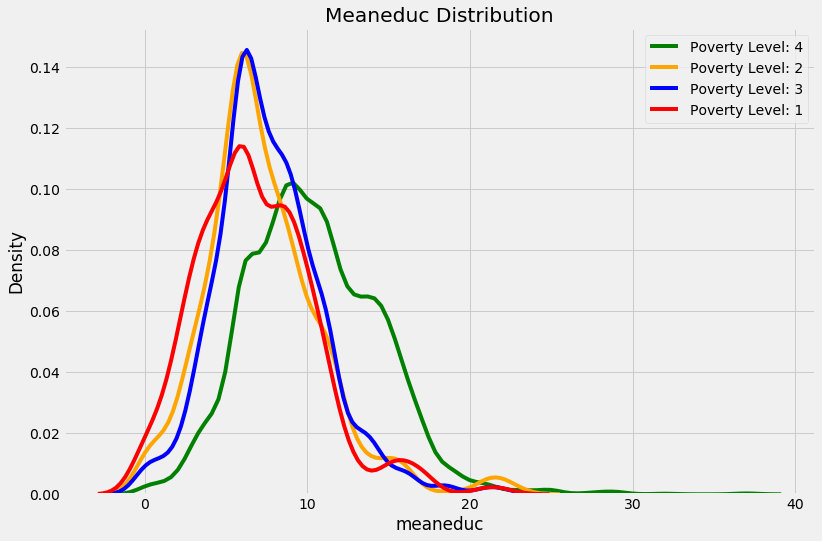

In [7]:
kde_target(train, 'meaneduc') #Average years of education for adults (18+)

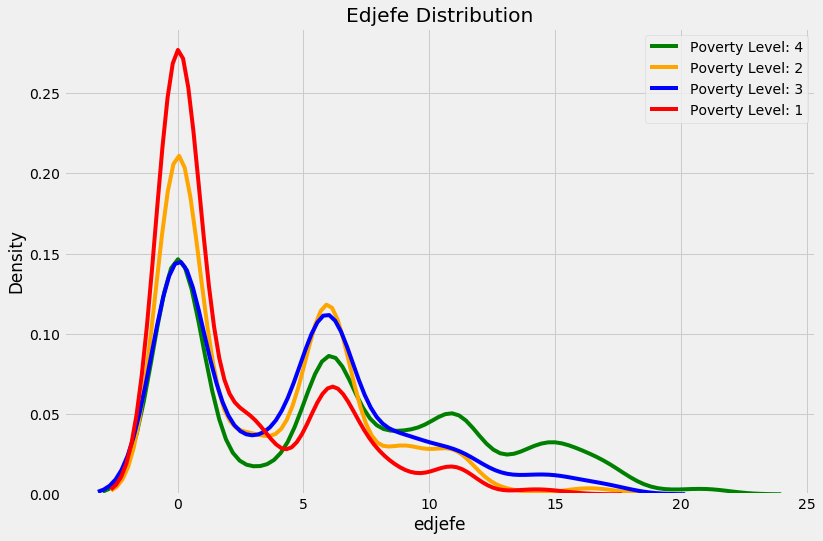

In [8]:
kde_target(train, 'edjefe') #Years of education of male head, interact escolari and demographic variables

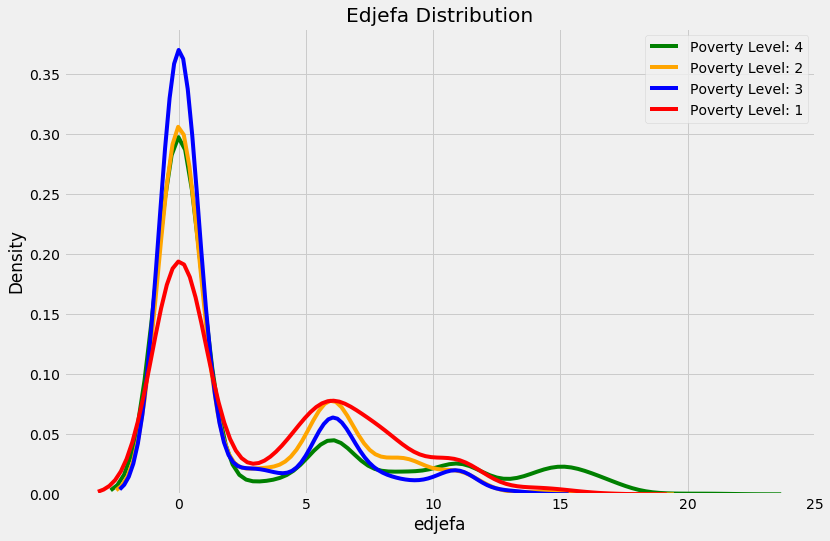

In [9]:
kde_target(train, 'edjefa') #Years of education of female head, interact escolari and demographic variables

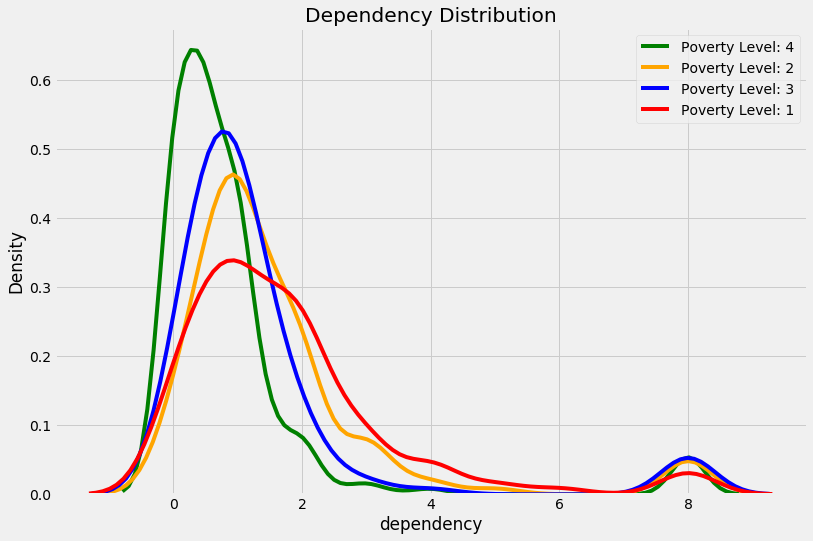

In [10]:
kde_target(train, 'dependency') #Dependency rate = (<19 + 64<)/(19<<64) 

Dependency definitely has something weird going on with the spike at 8. Let's examine it a bit closer. 

In [11]:
check_train = train.loc[(train['dependency'] == 8)]
group = check_train.groupby(['hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total'])
output = group.size().reset_index().rename(columns={0:'frequency'})
targets = group['Target'].mean().reset_index()
ages = group['age'].mean().reset_index()
output['mean_age'] = ages.age
output['mean_target'] = targets.Target
output

,hogar_nin,hogar_adul,hogar_mayor,hogar_total,frequency,mean_age,mean_target
0,0,1,1,1,135,74.896296,3.311111
1,0,2,2,2,196,74.428571,3.346939
2,0,3,3,3,6,79.166667,3.000000
3,1,0,0,1,1,18.000000,4.000000
4,1,1,1,2,8,41.750000,2.750000
5,1,2,2,3,15,55.800000,2.800000
6,2,0,0,2,4,18.500000,4.000000
7,2,2,2,4,4,42.500000,2.000000
8,8,1,0,9,9,11.666667,1.000000


It looks like most of them are accounted for by 1-3 seniors living alone without any children or adults between the ages of 19 and 64. Let's assume they're supporting themselves (since they are, on average, doing at least okay in terms of poverty level) and set their dependency to 0. 

There some cases of 1-2 children with no adults. Since their mean age is 18 (and I checked it using the filters in Kaggle... all of them are 18 or 19), and since they're not vulnerable to poverty (which means they're most likely supporting themselves so they're not dependent), we'll set their dependency to 0.

That leaves rows 4, 5, 7, and 8. 4, 5, and 7 look like 1-2 children living with 1-2 seniors, probably grandparents. We'll recalculate their dependency based on number of children divided by number of seniors. Row 8 looks like it's actually correct, so we'll leave that one. 

In [12]:
for row, val in enumerate(train.dependency):
    if val == 8:
        children = train.loc[row, 'hogar_nin']
        adults = train.loc[row, 'hogar_adul']
        seniors = train.loc[row, 'hogar_mayor']
        if children == 0:
            train.loc[row, 'dependency'] = 0
        elif adults == 0: 
            train.loc[row, 'dependency'] = 0
        elif adults == seniors:
            train.loc[row, 'dependency'] = children / float(seniors) #Casting as float to ensure we don't have integer division
        else:
            continue #Ignore the row where it's correct

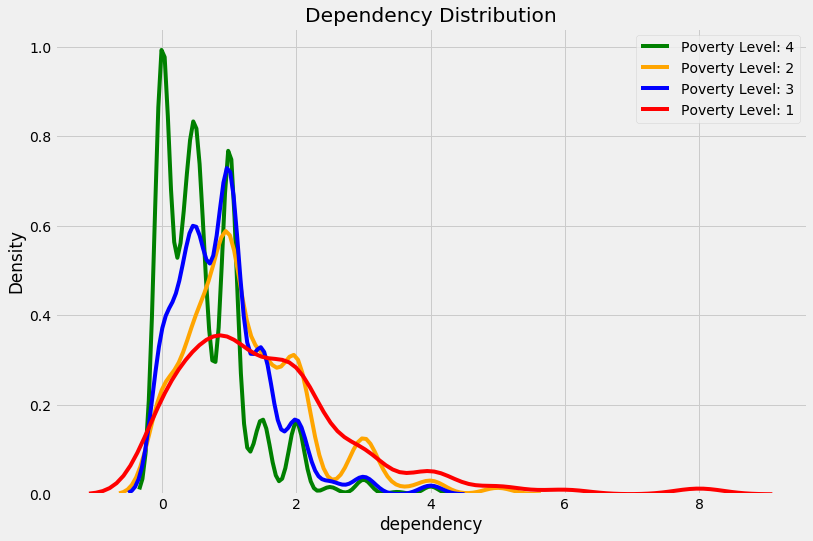

In [13]:
kde_target(train, 'dependency') #Dependency rate = (<19 + 64<)/(19<<64) 

Alright, that looks better. Definitely less smooth, but more plausible without the big spike at 8. 

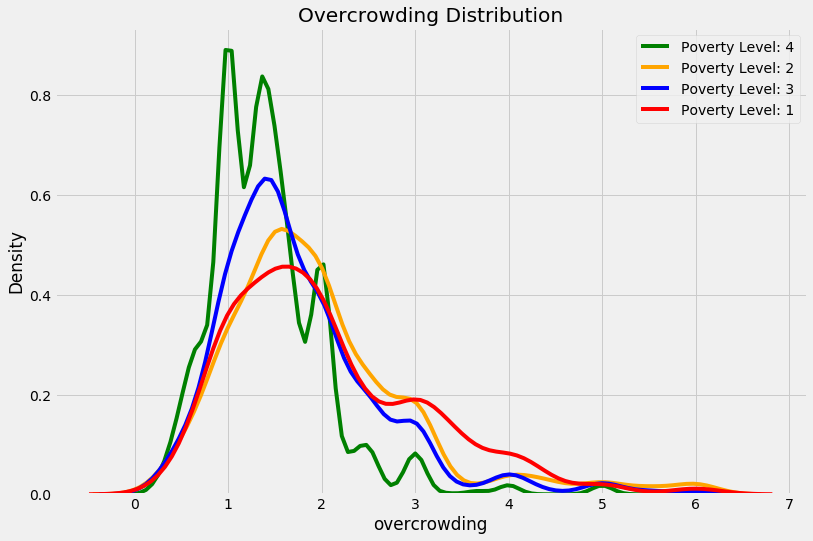

In [14]:
kde_target(train, 'overcrowding') #Persons per room. There are two flag variables, hacdor and hacapo, that say they are 
                                  #"Overcrowding by room" and "Overcrowding by bedrooms", but we won't worry about them for now.

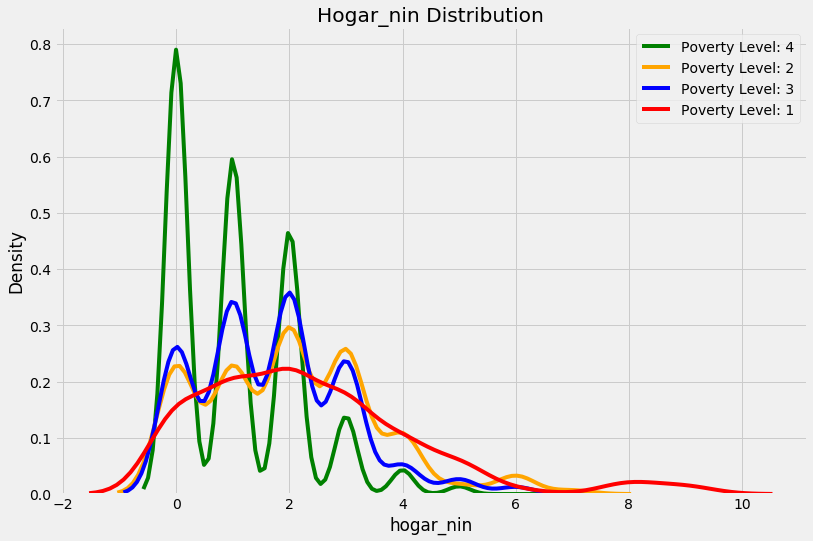

In [15]:
kde_target(train, 'hogar_nin')

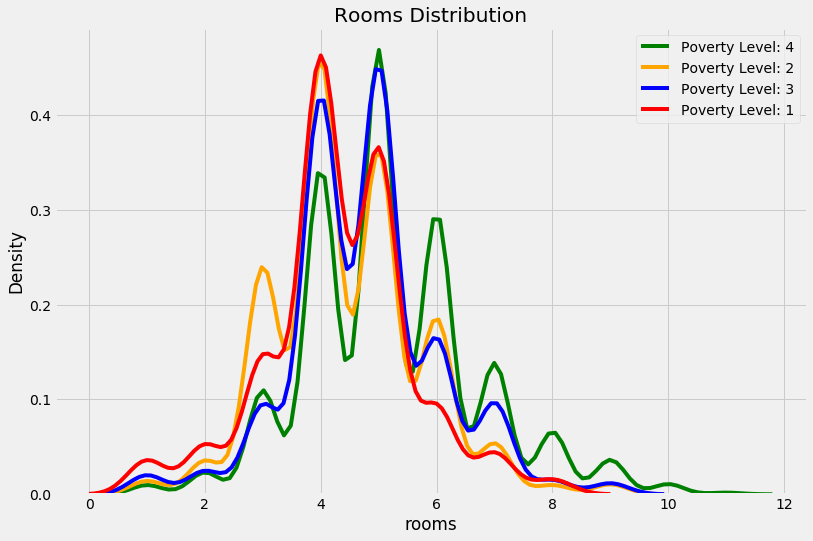

In [16]:
kde_target(train, 'rooms') #Number of all rooms in the house

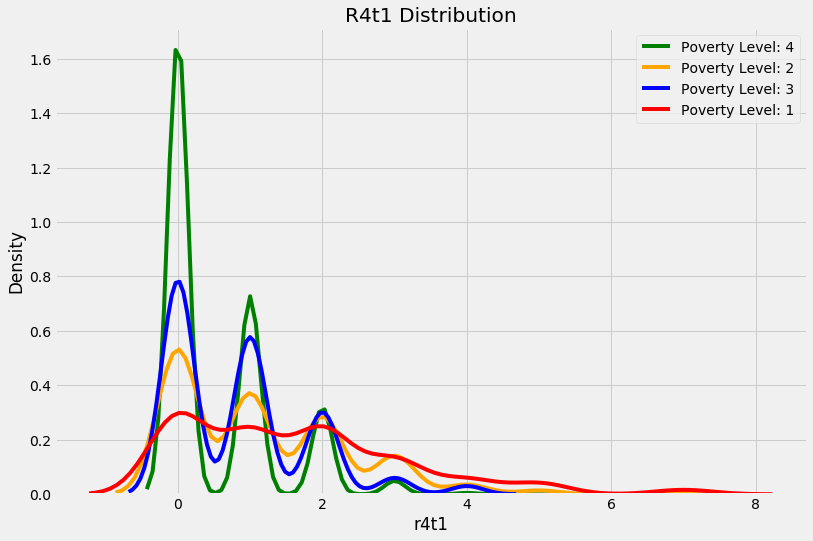

In [17]:
kde_target(train, 'r4t1') #Persons younger than 12 years of age

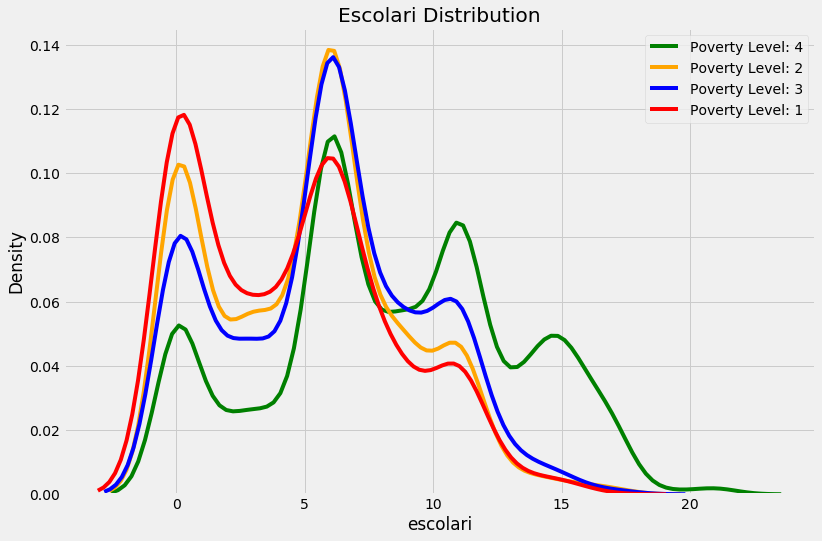

In [18]:
kde_target(train, 'escolari') #years of schooling (per individual), we probably want to look at households.

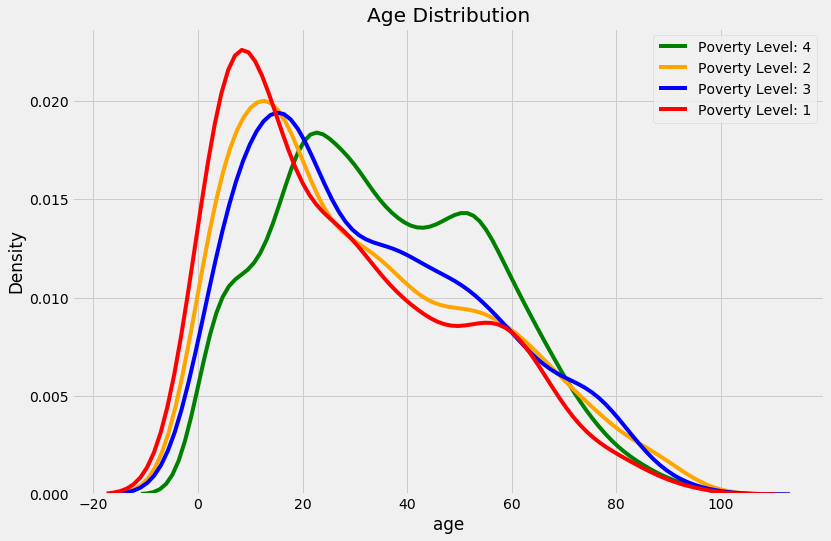

In [19]:
kde_target(train, 'age')

## Feature Engineering
Again, the kernel referenced above has some really fantastic treatment of aggregating the individual things to be at a household level. I've gone through what he does and I understand it, and, since we're making predictions for households, I'll include it here and do the same to my data. 

In [20]:
id_ = ['Id', 'idhogar', 'Target']

ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone']
ind_ordered = ['rez_esc', 'escolari', 'age']

hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2']
hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']
hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [21]:
#Start with household data, subsetting to heads of household and then to household level variables.
heads = train.loc[train['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(2973, 98)

In [22]:
#Make the individual level dataframe.
ind = train[id_ + ind_bool + ind_ordered]
ind.shape

(9557, 39)

In [23]:
#My own feature I created:
water = []

# Assign values
for i, row in heads.iterrows():
    if row['abastaguano'] == 1:
        water.append(0)
    elif row['abastaguafuera'] == 1:
        water.append(1)
    elif row['abastaguadentro'] == 1:
        water.append(2)
    else:
        water.append(np.nan)
        
# Record the new variable and missing flag
heads['water'] = water

#I think these ones are just really great ideas from Will. So here they are: 
# Walls ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['water'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['noelec'] + 
                         (heads['cielorazo'] == 0))
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['escolari/age'] = ind['escolari'] / ind['age']

C:\Users\garrett.bergeson\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\garrett.bergeson\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
#There are a bunch of 'inst' variables describing how much schooling someone has. Turn them into an ordinal variable
# (as Will Koehrsen does)
ind['inst'] = pd.Series(np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1), index=ind.index)
ind.drop(columns = [c for c in ind if c.startswith('instlevel')], inplace=True)
#For some reason these give warnings but they work anyway. Sorry about the warnings.

C:\Users\garrett.bergeson\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\garrett.bergeson\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [25]:
#Aggregate the individual level variables
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ... escolari/age  \
           min max sum count  std range_ min max sum count  ...          sum   
idhogar                                                     ...                
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...     0.421053   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...     0.554348   
004616164    0   0   0     2  0.0      0   0   0   0     2  ...     0.747500   
004983866    0   0   0     2  0.0      0   0   0   0     2  ...     0.573093   
005905417    0   0   0     3  0.0      0   0   0   0     3  ...     0.852679   

                                    inst                                 
          count       std    range_  min max sum count       std range_  
idhogar                                                                  
001ff74ca     1       NaN  0.000000    0   7   7     2  4.949747      7  
003123ec2     4  0.161557  0.304348    0   3   5     4  1.500000      3  
004616164     2  0.443710  0.627500    1   4   5     2  2.121320      3  
004983866     2  0.213480  0.301907    3   3   6     2  0.000000      0  
005905417     3  0.285726  0.571429    0   3   6     3  1.732051      3  

[5 rows x 180 columns]

In [26]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.421053,1,NaN,0.000000,0,7,7,2,4.949747,7
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.554348,4,0.161557,0.304348,0,3,5,4,1.500000,3
004616164,0,0,0,2,0.0,0,0,0,0,2,...,0.747500,2,0.443710,0.627500,1,4,5,2,2.121320,3
004983866,0,0,0,2,0.0,0,0,0,0,2,...,0.573093,2,0.213480,0.301907,3,3,6,2,0.000000,0
005905417,0,0,0,3,0.0,0,0,0,0,3,...,0.852679,3,0.285726,0.571429,0,3,6,3,1.732051,3


In [28]:
# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')
print('Final features shape: ', final.shape)

Final features shape:  (2973, 281)


In [29]:
#Check for missing data from our aggregation
# Number of missing in each column
missing = pd.DataFrame(final.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(final)

missing.sort_values('percent', ascending = False).head(300)

,total,percent
escolari/age-std,389,0.130844
parentesco1-std,388,0.130508
parentesco2-std,388,0.130508
escolari-std,388,0.130508
estadocivil7-std,388,0.130508
rez_esc-std,388,0.130508
male-std,388,0.130508
mobilephone-std,388,0.130508
dis-std,388,0.130508
parentesco12-std,388,0.130508


In [30]:
#There are a lot of standard deviations that are missing data. Let's fill them with zero.
final.fillna(0, inplace=True)

## Start testing

In [44]:
#Drop squared variables -- too highly correlated with linear variables. 
train = train.drop(['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq'], axis=1)
temp = final.drop(columns = ['Id', 'idhogar'])
y = temp.Target
x = temp.drop(columns='Target')
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=848591)

### Random Forest

In [45]:
'''
I've done some hyperparameter tuning here just by looking at different values of the estimators and the criterion. 
It looks like entropy consistently produces better results than gini, and 750 does better than numbers on either side of it.
'''

classifier = RandomForestClassifier(n_estimators=750, criterion='entropy', random_state=848591)
classifier.fit(x_train, y_train);

In [46]:
predictions = classifier.predict(x_test)
test_pred = predictions.tolist()

accuracy = classifier.score(x_test, y_test) * 100
num_wrong = (100 - accuracy) * len(y_test) / 100
print("Accuracy: {}%  Number wrong: {}".format(str(round(accuracy, 2)), str(round(num_wrong, 0))))
print('F1 score:', round(metrics.f1_score(y_test, test_pred, average='micro'), 5))
#I use micro here instead of macro because there's a lot of data labeled as non-vulnerable compared to other classes.

Accuracy: 69.09%  Number wrong: 230.0
F1 score: 0.69086


In [47]:
# In addition, we'll use cross validation to make sure we aren't overfitting on that test set.
scores = cross_val_score(classifier, x_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(classifier, x_train, y_train, cv=5, scoring='f1_micro')
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(classifier, x_train, y_train, cv=5, scoring='precision_micro')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(classifier, x_train, y_train, cv=5, scoring='recall_micro')
print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.67 (+/- 0.04)
F1: 0.67 (+/- 0.04)
Precision: 0.67 (+/- 0.04)
Recall: 0.67 (+/- 0.04)


It's odd to me that they're all exactly the same. It looks like the model is predicting the same amount of false positives as false negatives, since that's what precision and recall measure, respectively. 

Confusion matrix, without normalization
[[ 10  13   0  32]
 [  3  28   2  78]
 [  2  11   4  69]
 [  4  12   4 472]]


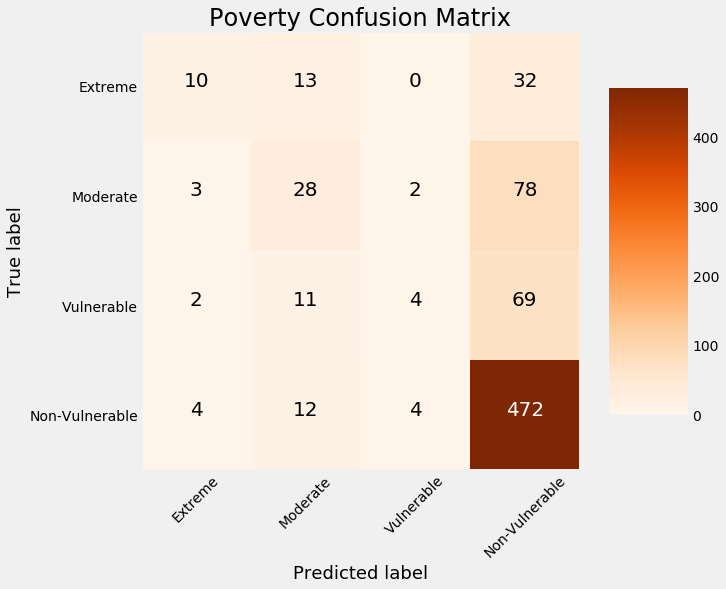

In [48]:
cm = confusion_matrix(y_test, predictions)

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

In [49]:
important_features = pd.DataFrame({'feature': x_train.columns, 'importance': classifier.feature_importances_})
important_features.head()

,feature,importance
0,hacdor,0.000626
1,hacapo,0.000472
2,v14a,0.000277
3,refrig,0.001756
4,paredblolad,0.006462


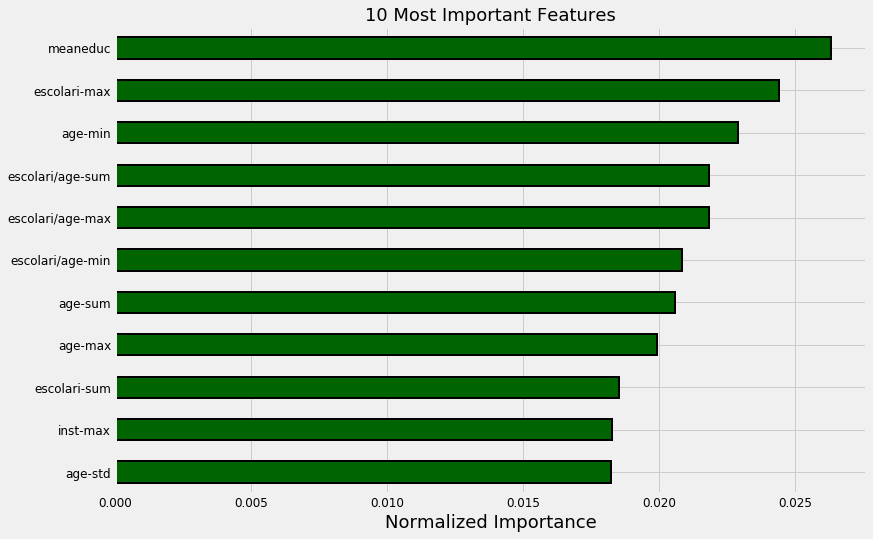

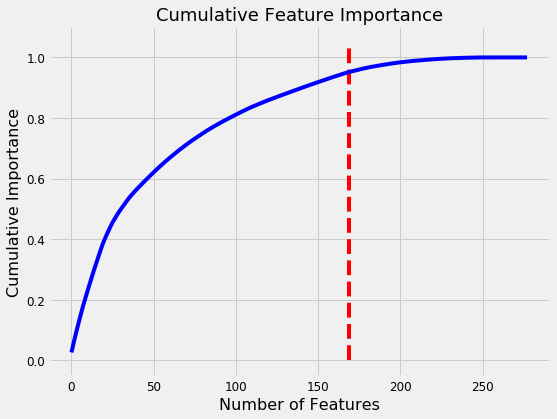

169 features required for 95% of cumulative importance.


In [50]:
plot_feature_importances(important_features, threshold=0.95);

### Naive Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
predictions = nb.predict(x_test)

scores1 = cross_val_score(nb, x_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))
scores2 = cross_val_score(nb, x_train, y_train, cv=5, scoring='f1_micro')
print("F1: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
scores3 = cross_val_score(nb, x_train, y_train, cv=5, scoring='precision_micro')
print("Precision: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))
scores4 = cross_val_score(nb, x_train, y_train, cv=5, scoring='recall_micro')
print("Recall: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std() * 2))

Accuracy: 0.27 (+/- 0.02)
F1: 0.27 (+/- 0.02)
Precision: 0.27 (+/- 0.02)
Recall: 0.27 (+/- 0.02)


Again, strange that they're all the same, but oh well. Let's try the same thing but with only the top ten most important features from our random forest. 

In [66]:
important_feats = ['meaneduc','escolari-max','age-min','escolari/age-sum','escolari/age-max','escolari/age-min',
                  'age-sum','age-max','escolari-sum','inst-max','age-std']

#Tried with different hyperparameters: alpha as 0.1 and .5. No difference 
nb1 = MultinomialNB(alpha=.5)
nb1.fit(x_train[important_feats], y_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [67]:
predictions = nb.predict(x_test[important_feats])

scores1 = cross_val_score(nb1, x_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))
scores2 = cross_val_score(nb1, x_train, y_train, cv=5, scoring='f1_micro')
print("F1: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
scores3 = cross_val_score(nb1, x_train, y_train, cv=5, scoring='precision_micro')
print("Precision: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))
scores4 = cross_val_score(nb1, x_train, y_train, cv=5, scoring='recall_micro')
print("Recall: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std() * 2))

Accuracy: 0.27 (+/- 0.02)
F1: 0.27 (+/- 0.02)
Precision: 0.27 (+/- 0.02)
Recall: 0.27 (+/- 0.02)


No improvement. Too bad. Probably to find improvement here, we'd have to delve even deeper into the data and remove as many correlated variables as possible, as well as continue working to engineer the right new features that would help the naive classifier work better. It's also possible we could do an algorithm that classifies the target classes in order, instead of all at once. 

In conclusion, I think that the Random Forest is better because it has a higher baseline. The amount of work required to get it going at a higher baseline is not as much as the naive Bayes classifier. Additionally, it shows which features are important and help the most in getting an accurate prediction. This is extremely important when working in business so as to show which features are necessary and which we should pay most close attention to. It also helps give understanding to the structure of extreme poverty in Costa Rica and how the government there may be able to help families in need.